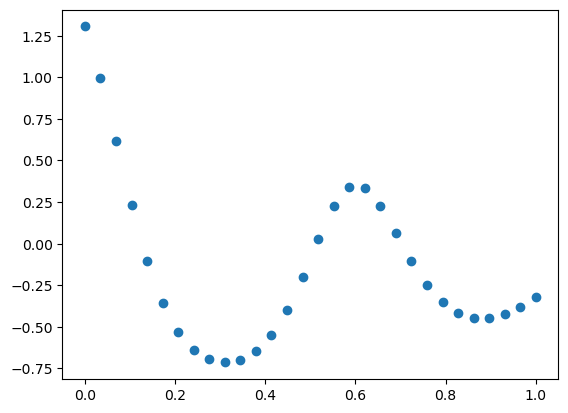

In [1]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
from known_boundary.SLogGP import SLogGP

np.random.seed(0)


X_init = np.array([0.0]).reshape(-1,1)
Y_init = np.array([0.0]).reshape(-1,1)

kernel = GPy.kern.RBF(input_dim=1,lengthscale= 0.2,variance=0.5)  #np.sqrt(res[0])
model_test = GPy.models.GPRegression(X_init, Y_init,kernel)

X_test = np.linspace(0,1,30).reshape(-1,1)
Y_test = np.exp(0.5+model_test.posterior_samples_f(X_test,size=1).reshape(-1,1))-1

plt.scatter(X_test,Y_test)

In [83]:
#check posterior
mus_prior = [0,0,0]
sigmas_prior = [2,2,2]
loc_prior = [0,0,0]

prior = lambda x: Log_parameter_prior (mus_prior,sigmas_prior,loc_prior,parameters=x)
print(prior([0.2,1.3,1.]))

posterior_SLogGP(X_test, Y_test, prior,parameter=[0.1,1.,1.1])

-3.82157416848347


70.49895245691451

In [17]:
import math
from scipy import stats

def logNormal_pdf (mu,sigma,loc,x):  # for lengthscale and variance, loc =0; for c, loc = - Y_min
    # in addition, when the prior mu of c should be calculated so that the mean of logNormal is equal to prior boundary information
    
    return stats.lognorm(s=sigma, scale=math.exp(mu),loc=loc).pdf(x)

def Log_parameter_prior (mus_prior,sigmas_prior,loc_prior,parameters):  #this function calculate the log of prior distribution
    
    # parameter is [lengthscale,variance,c], here we view sigma^2 (variance) as a whole
    
    log_likelihood = 0.
    
    for i in range(3):  #Assume three parameters are independent, so the likelihood is the multiplication
        mu = mus_prior[i]
        sigma = sigmas_prior[i]
        loc = loc_prior[i]
        parameter = parameters[i]
        
        log_likelihood += np.log(logNormal_pdf (mu,sigma,loc,parameter))
        
    return log_likelihood

In [18]:
def posterior_SLogGP(X, Y, Log_parameter_prior,parameter):   #this function calculate the log posterior
    
    #parameter is [lengthscale,variance,c]
    
    m = GPy.models.WarpedGP(X, Y,warping_function=SLogGP(lower=-np.min(Y)+10**(-6),upper=-np.min(Y)+10**(-6)+500,n_terms =1))
    
    m.rbf.lengthscale = parameter[0]
    m.rbf.variance = parameter[1]
    m.SlogGP.psi = parameter[2]
    m.Gaussian_noise.fix(1e-6)
     
    loglik = m.log_likelihood()
    logprior = (Log_parameter_prior(parameter))  #this is prior distribution of parameter (theta)
    
    return loglik + logprior

In [ ]:
def Uniform_proposal(current_parameter,loc_holder):  # This is Q
    # proposal based on Gaussian
    
    parameter_new = []
    
    range = [0.01,2]
    
    for i in range(3):
        loc = loc_holder[i]
        mu = current_parameter[i]
        
        parameter_new_temp = stats.lognorm(s=0.02, scale=math.exp(mu),loc=loc).rvs()  #.rvs()表示生成一个random sample
        parameter_new.append(parameter_new_temp)
        
    return parameter_new

In [19]:
def LogNormal_proposal(current_parameter,loc_holder):  # This is Q
    # proposal based on Gaussian
    
    parameter_new = []
    
    range = [0.01,2]
    
    for i in range(3):
        loc = loc_holder[i]
        mu = current_parameter[i]
        
        parameter_new_temp = stats.lognorm(s=0.02, scale=math.exp(mu),loc=loc).rvs()  #.rvs()表示生成一个random sample
        parameter_new.append(parameter_new_temp)
        
    return parameter_new


def LogNormal_proposal_prob(parameter1, parameter2,loc_holder): 
    # calculate proposal probability q(x2|x1), based on Gaussian
    
    q = 1.
    for i in range(3):
        
        q_temp = stats.lognorm(s=0.02, scale=math.exp(parameter1[i]),loc=loc_holder[i]).pdf(parameter2[i])
        
        q = q*q_temp
    return q

In [20]:
def mcmc_mh_posterior(X, Y, parameter_init, posterior_SLogGP, Log_parameter_prior,LogNormal_proposal, LogNormal_proposal_prob, loc_holder,n_iter=1000): #X is the observation, func is posterior (分子)，proposal_func 是Q
    # Metropolis-Hastings to estimate posterior
    
    parameters_history = []
    current_parameter = parameter_init  #x_t
    
    accept_rates = []
    accept_cum = 0
    
    for i in range(1, n_iter+1):
        parameter_new = LogNormal_proposal(current_parameter,loc_holder=loc_holder)
        
        prob_curr = posterior_SLogGP(X, Y, Log_parameter_prior,current_parameter)  
        prob_new = posterior_SLogGP(X, Y, Log_parameter_prior,parameter_new)    
        
        # we calculate the prob=exp(x) only when prob<1 so the exp(x) will not overflow for large x
        if prob_new > prob_curr:
            acceptance_ratio = 1
        else:
            # qr = LogNormal_proposal_prob(parameter_new,current_parameter,loc_holder)/LogNormal_proposal_prob(parameter_new, current_parameter,loc_holder)
            # print(qr)
            qr = 1
            acceptance_ratio = np.exp(prob_new - prob_curr) * qr
            
        print(acceptance_ratio)
        acceptance_prob = min(1, acceptance_ratio)
        
        if acceptance_prob > stats.uniform(0,1).rvs():
            current_parameter = parameter_new
            accept_cum = accept_cum+1
            parameters_history.append(parameter_new)
        else:
            parameters_history.append(current_parameter)
            
        accept_rates.append(accept_cum/i)
        
    return parameters_history, accept_rates

In [23]:
#check posterior
mus_prior = [0,0,0]
sigmas_prior = [1,1,0.2]
loc_prior = [0,0,-np.min(Y_test)]

prior = lambda x: Log_parameter_prior (mus_prior,sigmas_prior,loc_prior,parameters=x)

thetas, accept_rates = mcmc_mh_posterior(X_test, Y_test,[0.1,0.8,0.9],posterior_SLogGP,prior,LogNormal_proposal,LogNormal_proposal_prob,loc_holder = [0,0,-np.min(Y_test)],n_iter=1000)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [98]:
mus_prior = [0,0,0]
sigmas_prior = [2,2,2]
loc_prior = [0,0,0]

prior = lambda x: Log_parameter_prior (mus_prior,sigmas_prior,loc_prior,parameters=x)
print(prior([0.2,1.3,1.]))

posterior_SLogGP(X_test, Y_test, prior,parameter=[0.1,1,.9])

-3.82157416848347


79.29635628128356

In [97]:
np.min(Y_test)

-0.7138605543306269

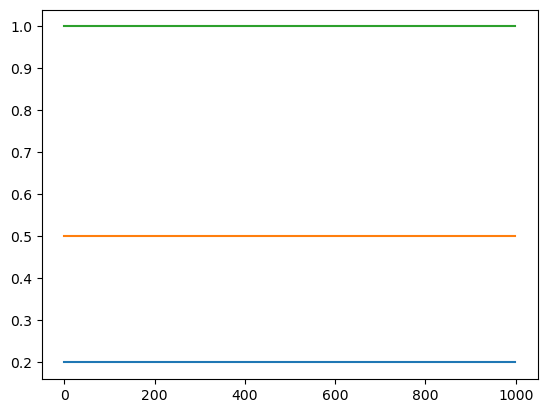

In [10]:
plt.plot(thetas)

In [11]:
thetas

[[0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0.5, 1],
 [0.2, 0

In [102]:
thetas

[[0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1, 0.9],
 [0.1, 1

In [100]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import seaborn as sns

def plot_res(xs, burn_in, x_name):
    # plot trace (based on xs), distribution, and autocorrelation

    xs_kept = xs[burn_in:]

    # plot trace full
    fig, ax = plt.subplots(2,2, figsize=(15,5))
    ax[0,0].plot(xs)
    ax[0,0].set_title('Trace, full')

    # plot trace, after burn-in
    ax[0,1].plot(xs_kept)
    ax[0,1].set_title('Trace, after discarding burn-in')

    # plot distribution, after burn-in
    sns.histplot(xs_kept, ax=ax[1,0])
    ax[1,0].set_xlabel(f'{x_name} (after burn-in)')

    # plot autocorrelation, after burn-in
    plot_acf(np.array(xs_kept), lags=100, ax=ax[1,1], title='')
    ax[1,1].set_xlabel('Lag (after burn-in)')
    ax[1,1].set_ylabel('Autocorrelation')

plot_res(thetas, 500, 'theta')
print(f"Mean acceptance rate: {np.mean(accept_rates[500:]): .3f}")

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
mus_prior = []
sigmas_prior = []

In [ ]:
parameter = [0.4,1.,0.]

posterior_SLogGP(X_test, Y_test, Log_parameter_prior,parameter)

In [31]:
print(stats.lognorm(s=0.01, scale=math.exp(1),loc=1).ppf(0.15))
print(stats.lognorm(s=0.01, scale=math.exp(1),loc=1).ppf(0.85))

3.690254143006208
3.7466015127752184


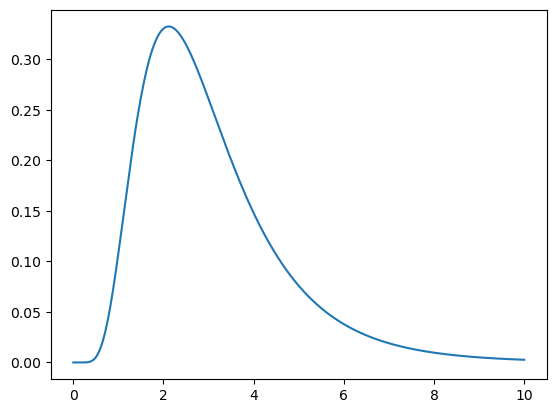

In [17]:
from scipy import stats

pdf_function = stats.lognorm(s=0.5, scale=math.exp(1))

X_total = np.linspace(0,10,500) 
pdf_holder = []
for x in X_total:
    res = pdf_function.pdf(x)
    pdf_holder.append(res)

plt.plot(X_total,np.array(pdf_holder))

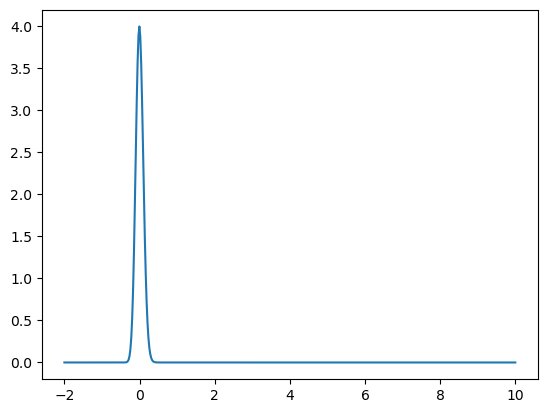

In [36]:
# if -y_min = -2, the prior boundary information is 0, then

X_total = np.linspace(-2,10,500) 
pdf_holder = []
for x in X_total:
    pdf = (logNormal_pdf (mu=np.log(2),sigma=0.05,loc=-2,x=x))
    pdf_holder.append(pdf)
    
plt.plot(X_total,np.array(pdf_holder))

In [25]:
X_total = np.linspace(0,10,500) 
pdf_holder = []
for x in X_total:
    pdf = (logNormal_pdf (mu=1,sigma=0.01,x=x))
    pdf_holder.append(pdf)
    


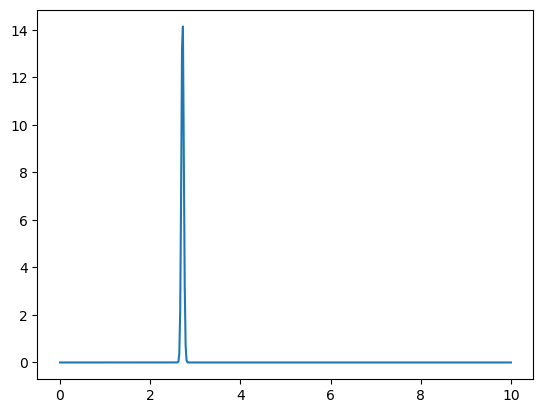

In [26]:
plt.plot(X_total,np.array(pdf_holder))